**Part I**

In [1]:
import pymc as pm
import arviz as az

In [2]:
from scipy import stats; import numpy as np; import matplotlib.pyplot as plt
mu_0,sigma_0=0,10
n,loc_true,scale_true,df_true = 100,10,2,15
x = stats.t(df=df_true, loc=loc_true, scale=scale_true).rvs(n)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
loc_prior,10.06,0.24,9.61,10.52,0.00,0.00,5151.42,4414.76,1.00
df_prior,60.42,25.72,17.00,100.00,9.66,7.44,8.04,281.06,1.17
scale_prior,2.38,0.18,2.04,2.73,0.00,0.00,3501.11,2306.91,1.01


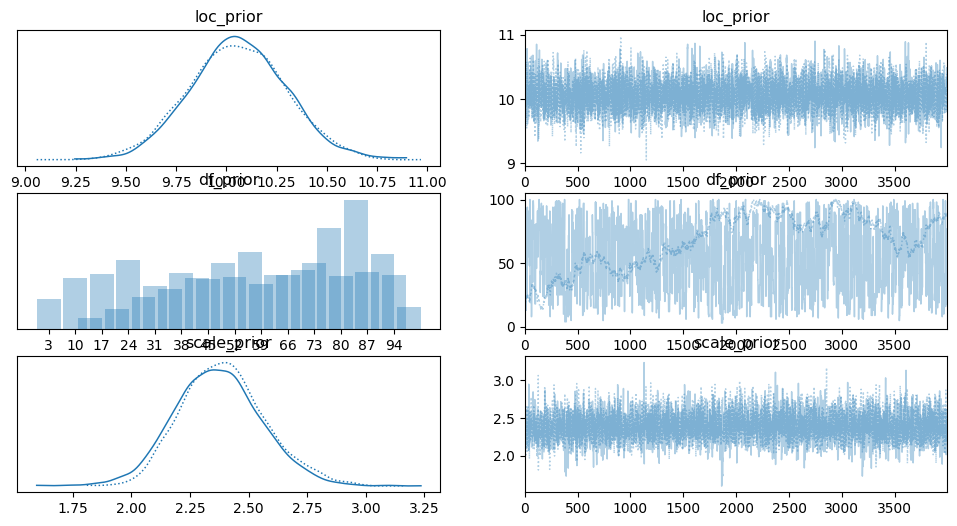

In [40]:
model = pm.Model()
with model:
    loc_prior = pm.Normal('loc_prior', mu=mu_0, sigma=sigma_0)
    scale_prior = pm.HalfNormal('scale_prior', sigma=5)
    df_prior = pm.DiscreteUniform('df_prior', lower=1, upper=100)
    likelihood = pm.StudentT('likelihood', mu=loc_prior, lam=1/scale_prior**2, nu=df_prior, observed=x)
    trace = pm.sample(draws=4000, tune=3000, target_accept=0.95)
az.plot_trace(trace)
az.summary(trace, round_to=2)

In [41]:
# Effective sample sizes
df_summary = az.summary(trace, var_names=['df_prior'], round_to=2)
df_samplesize = df_summary['ess_bulk']
print(f"The sample sizes needed for the df parameter: {df_samplesize}")

The sample sizes needed for the df parameter: df_prior    8.04
Name: ess_bulk, dtype: float64


**Part II**

In [19]:
import numpy as np
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

In [21]:
with pm.Model() as Centered_eight:
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J)
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

SEED = [10069, 73893]
with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})

In [22]:
with pm.Model() as NonCentered_eight:
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

with NonCentered_eight:
    fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                       return_inferencedata=True, idata_kwargs={"log_likelihood": True})

In [44]:
# (a) effective sample sizes
import pandas as pd
print("Effective Sample Sizes (function of Markov Chain autocorrelation dependency)")
pd.concat(
[pd.DataFrame({'Centered': pm.summary(fit_C)[:1]['ess_bulk'],
              'Non-Centered': pm.summary(fit_NC)['ess_bulk'][:1]}),
 pd.DataFrame({'Centered': pm.summary(fit_C)[1:]['ess_bulk'],
              'Non-Centered': pm.summary(fit_NC)['ess_bulk'][9:]})])

Effective Sample Sizes (function of Markov Chain autocorrelation dependency)


,Centered,Non-Centered
mu,1098.0,13474.0
tau,347.0,4285.0
theta[0],1958.0,9788.0
theta[1],1929.0,14132.0
theta[2],1885.0,12050.0
theta[3],2017.0,13935.0
theta[4],1591.0,11192.0
theta[5],1914.0,13577.0
theta[6],1701.0,11522.0
theta[7],2136.0,12381.0


In [54]:
# (b) chain convergence measures
r_hat_C_mu = az.summary(fit_C, var_names=['mu'])['r_hat'].iloc[0]
r_hat_C_tau = az.summary(fit_C, var_names=['tau'])['r_hat'].iloc[0]

r_hat_NC_mu = az.summary(fit_NC, var_names=['mu'])['r_hat'].iloc[0]
r_hat_NC_tau = az.summary(fit_NC, var_names=['tau'])['r_hat'].iloc[0]

print("Chain Convergence")
pd.concat(
[pd.DataFrame({'Centered': [r_hat_C_mu, r_hat_C_tau],
                    'Non-Centered': [r_hat_NC_mu, r_hat_NC_tau]},
                   index=['mu', 'tau'])])

Chain Convergence


,Centered,Non-Centered
mu,1.00,1.0
tau,1.01,1.0


In [59]:
# (c) divergences
divergences_C = fit_C.sample_stats['diverging'].sum()
divergences_NC = fit_NC.sample_stats['diverging'].sum()

print("Divergences:")
print(f"Centered: {divergences_C}")
print(f"Non-Centered: {divergences_NC}")

Divergences:
Centered: <xarray.DataArray 'diverging' ()>
array(176)
Non-Centered: <xarray.DataArray 'diverging' ()>
array(2)


In [60]:
# (d) Metropolis-Hastings acceptance rates
acceptance_rate_C = fit_C.sample_stats['acceptance_rate'].values.flatten()
acceptance_rate_NC = fit_NC.sample_stats['acceptance_rate'].values.flatten()

print("Acceptance Rates:")
pd.concat(
[pd.DataFrame({'Centered': acceptance_rate_C,
    'Non-Centered': acceptance_rate_NC})])

Acceptance Rates:


,Centered,Non-Centered
0,0.455054,0.569709
1,0.508557,0.921768
2,0.704507,0.987013
3,0.850640,0.919249
4,0.907618,0.997576
...,...,...
9995,0.990713,0.965749
9996,0.965089,0.501027
9997,0.997715,0.995503
9998,0.993799,0.978999


In [62]:
# (e) any other warnings or concerns provided by PyMC
# There is no warnings.

**Why the "uncentered" paramterization of the model performs better than the "centered" parameterization:**

In the uncentered parameterization, the scaling of theta is fixed which is independent of tau. This effectively reduces the curvature of the energy function with respect to theta, making it smoother and more predictive. As a result, the HMC algorithm performs better because it can more efficiently explore the parameter space without getting stuck in high curvature regions.

In the centered parameterization, the scaling of theta by tau introduces high curvature in the density evaluations, especially when tau is small. This results in slower convergence and a higher chance of divergences for the HMC algorithm.

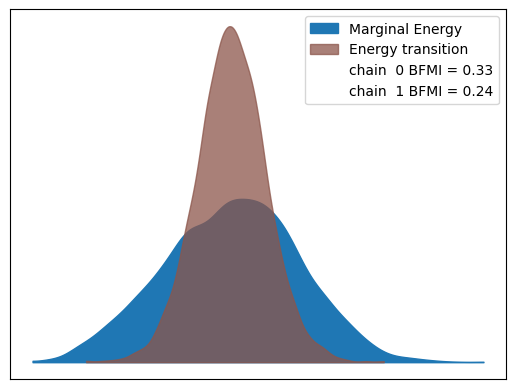

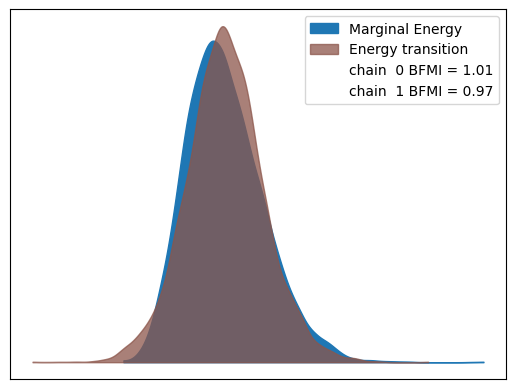

In [61]:
import arviz as az
az.plot_energy(fit_C);
az.plot_energy(fit_NC);

**Interpretation of the Diagnostic Plot:**

For the "centered" model (first model), the BFMI is notably low (0.33 and 0.24 for chain 0 and 1 respectively), suggesting a mismatch between the energy distribution of transitions and the marginal energy distribution. This discrepancy indicates potential challenges in sampling efficiency, likely attributable to the constraints imposed by the "centered" parameterization on the HMC algorithm's exploration of the posterior distribution.

In contrast, the "uncentered" model (second model) exhibits BFMI values much closer to 1 (1.01 and 0.97 for chain 0 and 1 respectively), indicative of a more harmonious alignment between energy transitions and marginal energy distribution. This alignment indicates the good performance of the sampling algorithm. The "uncentered" parameterization reduces the curvature of the energy function, leading to a smoother energy landscape and more effective sampling.

Thus, the diagnostic plot supports our previous conclusion regarding the effectiveness of the uncentered parameterization in reducing the energy function's curvature and improving the HMC algorithm's performance.





